In [1]:
from units.read import read_data_from_file_like, select_desired_columns
from units.processing import create_datetime_column, create_geodataframe, gdf_lines_and_stats_by_height
import os
import warnings
warnings.filterwarnings("ignore")  # Tắt tất cả các cảnh báo

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


ModuleNotFoundError: No module named 'geopandas'

In [2]:
file_path = 'output_06012014_12312015/tdump_14060100'

In [3]:
column_names = [
    'height_code',
    'tmp1',
    'year',
    'month',
    'day',
    'hour',
    'tmp2',
    'tmp3',
    'time_step',
    'n',
    'e',
    'height',
    'pressure',
    'air_temp',
    'rainfall',
    'relhumid'
]

In [4]:
# --- Example Usage ---

# 1. Reading from a file:
with open(file_path, "r") as file:
    df = read_data_from_file_like(file, column_names)
# 2. create datetime column
df = create_datetime_column(df)
# 3. Selecting desired columns:
df = select_desired_columns(df)
# 4. convert to geodataframe
gdf = create_geodataframe(df)
# 5. create lines and stats by height
gdf = gdf_lines_and_stats_by_height(gdf)

o:\tdump_reader\units\read.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_io, delim_whitespace=True, names=columns_name) # Add names parameter


In [5]:
gdf

,height_code,geometry,datetime,n,e,pressure,air_temp,relhumid,rainfall
0,1,"LINESTRING (105.24 10.72, 105.21 10.654, 105.1...",2014-06-01,10.72,105.24,961.433195,299.183402,76.319917,75.2
1,2,"LINESTRING (105.24 10.72, 105.24 10.667, 105.2...",2014-06-01,10.72,105.24,829.888797,291.592531,75.686722,95.9
2,3,"LINESTRING (105.24 10.72, 105.265 10.671, 105....",2014-06-01,10.72,105.24,781.795021,288.789627,76.985892,43.7


In [6]:
import pandas as pd
import geopandas
from shapely.geometry import Point, LineString
import os  # For file path handling
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you have the functions defined in previous responses:
# read_data_from_file_like, create_datetime_column,
# select_desired_columns, create_geodataframe, gdf_lines_and_stats_by_height

def process_and_combine_files(file_paths, column_names):
    """
    Processes a list of files, converts each to a GeoDataFrame, and combines them,
    with a progress bar.

    Args:
        file_paths (list): A list of file paths to process.
        column_names (list): column names list.

    Returns:
        geopandas.GeoDataFrame: A combined GeoDataFrame, or None if errors occur.
    """
    all_gdfs = []  # List to store GeoDataFrames from each file

    for file_path in tqdm(file_paths, desc="Processing files"):  # Add progress bar
        try:
            # 1. Reading from a file:
            with open(file_path, "r") as file:
                df = read_data_from_file_like(file, column_names)

            if df is None: # if the reading produce an error, skip this file.
                print(f"Skipping file {file_path} due to reading error.")
                continue

            # 2. create datetime column
            df = create_datetime_column(df)

            # 3. Selecting desired columns:
            df = select_desired_columns(df)

            # 4. convert to geodataframe
            gdf = create_geodataframe(df)

            # 5. create lines and stats by height
            gdf = gdf_lines_and_stats_by_height(gdf)

            if gdf is not None:
              all_gdfs.append(gdf) # collect the result if all steps go well.
            else:
              print(f"Skipping file {file_path} due to processing error.")

        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if all_gdfs:  # Check if we have any GeoDataFrames to combine
        if len(all_gdfs) > 1:
            try:
                # Concatenate all GeoDataFrames using pd.concat
                combined_gdf = geopandas.GeoDataFrame(
                    pd.concat(all_gdfs, ignore_index=True), crs=all_gdfs[0].crs
                )
                return combined_gdf
            except ValueError as e:
                print(f"Error concatenating GeoDataFrames: {e}")
                return None
        else:
            return all_gdfs[0] # Return the first gdf if only one file proceeded correctly.
    else:
        print("No GeoDataFrames were successfully processed.")
        return None

In [7]:
column_names = [
    'height_code',
    'tmp1',
    'year',
    'month',
    'day',
    'hour',
    'tmp2',
    'tmp3',
    'time_step',
    'n',
    'e',
    'height',
    'pressure',
    'air_temp',
    'rainfall',
    'relhumid'
]

In [8]:
file_names = os.listdir('output_06012014_12312015') # list all files in the directory
file_paths = [os.path.join('output_06012014_12312015', file_name) for file_name in file_names] # create full path for each file

In [10]:
# --- Example Usage ---

# Process the files
combined_gdf = process_and_combine_files(file_paths, column_names)

Processing files:   0%|          | 0/2316 [00:00<?, ?it/s]

Processing files: 100%|██████████| 2316/2316 [01:49<00:00, 21.12it/s]


In [20]:
# Nếu chưa có cột 'month'
combined_gdf['datetime'] = pd.to_datetime(combined_gdf['datetime'])  # đảm bảo kiểu datetime
combined_gdf['month'] = combined_gdf['datetime'].dt.month
combined_gdf['year'] = combined_gdf['datetime'].dt.year

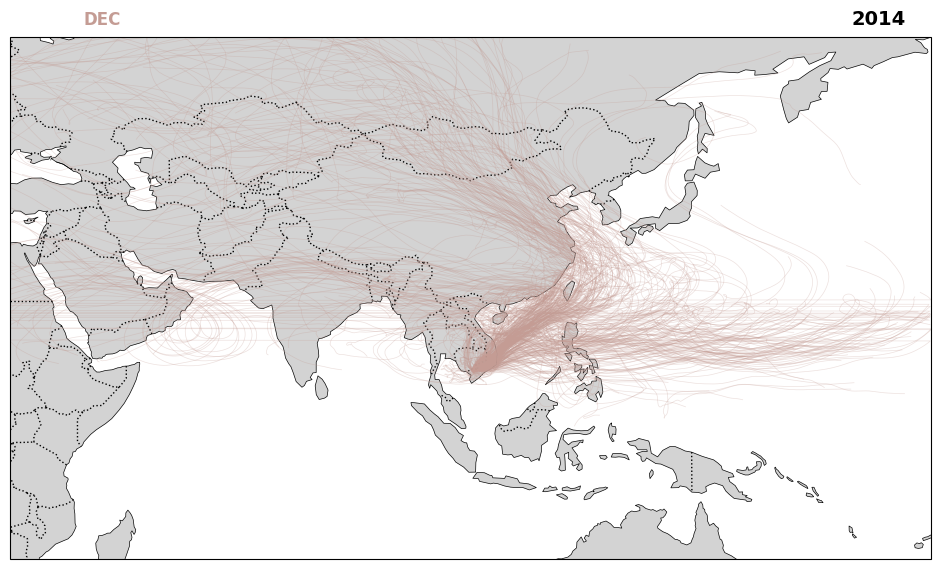

In [72]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

def plot_trajectories_all_months(gdf, month_column='month', year=2014):
    cmap = plt.get_cmap("tab20")
    month_colors = {month: cmap((month - 1) % 20) for month in range(1, 13)}

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Mở rộng phạm vi hiển thị bản đồ
    ax.set_extent([30, 180, -20, 65], crs=ccrs.PlateCarree())

    # Vẽ các đường
    available_months = sorted(gdf[month_column].dropna().unique())
    for month in available_months:
        sub_gdf = gdf[gdf[month_column] == month]
        for geom in sub_gdf.geometry:
            ax.plot(*geom.xy, color=month_colors.get(month, 'gray'),
                    linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

    # Vẽ bản đồ
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Ghi chú tên tháng – tăng fontsize và đẩy lên chút
    for i, month in enumerate(available_months):
        ax.text(42 + i * 10, 67, calendar.month_abbr[month].upper(),  # đổi từ 63 lên 67
                color=month_colors[month], fontsize=12, fontweight='bold')

    # Ghi chú năm – to hơn và canh sát góc hơn
    ax.text(167, 67, str(year), fontsize=14, fontweight='bold')

    # Điều chỉnh khoảng trắng khung
    plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.08)
    plt.show()



plot_trajectories_all_months(
    combined_gdf[
    (combined_gdf['year'] == 2014) &
    (combined_gdf['month'].isin([12]))],
    year=2014)

In [ ]:
month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }

In [80]:
combined_gdf[['height_code', 'datetime', 'n', 'e', 'pressure', 'air_temp',
       'relhumid', 'rainfall', 'month', 'year']].to_excel('combined_gdf.xlsx', index=False)

In [ ]:
combined_gdf.to_csv('combined_gdf.csv', index=False)

AttributeError: 'GeoDataFrame' object has no attribute 'to_xlsx'